In [1]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
import os
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
#use collagen to define dermis
# 1. extract collagen(class=10) from DLmask
# 2. remove small object and fill holes in collagen to make it a single connected body
# 3. find epidermal-dermis junction using maximum of the binary in y-axis
# 4. remove any pixels that are not epidermis above the epidermal-dermis junction
# 5. iterate each class to replace any potentially wrong pixel to correct class
    #hair foliical: adj pixel look at window

In [3]:
#read deeplab crop
dlcropsrc = r'\\fatherserverdw\kyuex\analysis output\datadst\20220929\dlcrop'

In [4]:
#1. remove small object and fill holes in collagen to make it a single connected body
#10x
dl = Image.open(os.path.join(dlcropsrc, "2022-06-07 14.34.59sec1.png"))

In [5]:

dl_arr = np.array(dl)
col = (dl_arr == 10) #collagen

In [6]:
#2.remove small object and fill holes in collagen to make it a single connected body

minTA = 60000
minTAhole = 10000 #is this too much?

#resize to expedite
(width, height) = (dl.width // 10, dl.height // 10)
collagen = Image.fromarray(col).resize((width, height), resample=0)

collagen= closing(collagen, square(3))  # 13sec
collagen= remove_small_objects(collagen, min_size=minTA, connectivity=2)  # 6sec
collagen = remove_small_holes(collagen , area_threshold=minTAhole).astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(collagen .astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
collagen = cv2.dilate(opening, kernel, iterations=3)

#resize back
collagen = Image.fromarray(collagen).resize((dl.width, dl.height),resample=0)
collagen_arr = np.array(collagen)

In [7]:
#3. find epidermal-dermis junction
[xt,yt] = np.where(collagen_arr)


In [8]:
#we actually want to find the minimum x-coordinate (because this image is weirdly oriented)
unique_y = np.unique(yt)


In [9]:

min_x = [np.amin(np.where(collagen_arr[:,y])) for y in unique_y]

In [10]:
thresh = 800 #i'm not sure that this will work with every image. TODO: change

In [11]:
hist, bins = np.histogram(min_x)

In [12]:
#get the value range to remove (note: this doesnt contain last element in bins
remove_bins = [b for h,b in zip(hist,bins) if h < thresh ]

In [13]:
#new junction, remove parts with low frequency in histogram,use remove_bins[0] because it represents where the junction begins to drop
#TODO: need to change this to be more robust, what if the junction drops in the middle,
new_junction_x  = [x for x in min_x if x < np.round(remove_bins[0].astype("uint32"))]
new_junction_y = list(range(len(new_junction_x)))

In [17]:
epi = deepcopy(dl_arr)

In [18]:

#epi should only have class 1 and 2
for x,y in zip( new_junction_x,new_junction_y):
    epi[x:, y] = 0

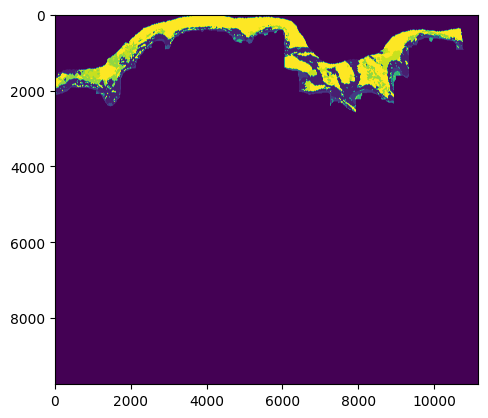

In [23]:
epi[collagen == 1] = 0
epi[:,max(new_junction_y):] = 0
plt.imshow(epi)

In [24]:
#????? is this right?
epi[epi == 0] = 12

In [25]:
#iterate through epi and replace value with 1 or 2, ignore 0 and 12
window_size = 3

for x in range(max(new_junction_x)):
    for y in range(max(new_junction_y)):
        if not (epi[x,y] == 0 or epi[x,y] == 1 or epi[x,y] == 2 or epi[x,y] == 12):

            #replace pixel value with 1 or 2
            window_shape = [(x -  window_size) if (x -  window_size) >=0 else 0,
                      (x + window_size) , y +  window_size,(y -  window_size) if (y - window_size) >=0 else 0] #L,R,T,B

            window = epi[window_shape[0]:window_shape[1], window_shape[3]:window_shape[2]]
            #check pixel values in window
            count1 = np.sum([window == 1])
            count2 = np.sum([window == 2])


            if(count1 >= count2):
                epi[x,y] = 1
            elif (count1 < count2):
                epi[x,y] = 2
            else:
                 epi[x,y] = 0



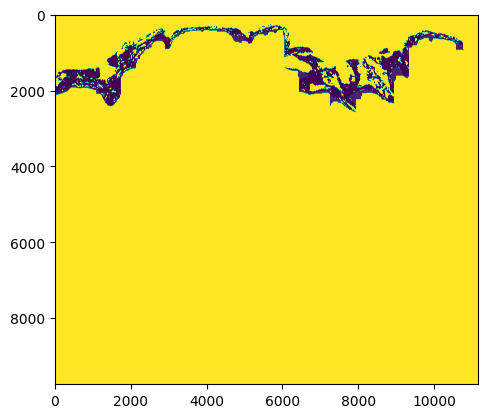

In [26]:
#now epidermis only has class 1 and 2
plt.imshow(epi)

In [151]:
from scipy import ndimage
import scipy

In [152]:
from skimage.measure import label, regionprops, regionprops_table

In [153]:
empty_derm = np.zeros(dl_arr.shape).astype("uint8")

In [154]:
#iterate through the classes 3-11 in derm
derm= deepcopy(dl_arr)
for x,y in zip( new_junction_x,new_junction_y):
    derm[0:x, y] = 0

In [362]:
#3 should have nothing else in it,should be touching four
derm3 = (derm == 3)
derm3 = ndimage.binary_fill_holes(derm3).astype(int)

#dilate derm3 to create a ring around derm3, check if the rings contain 4
#if not, remove everything in that ring
dilate3 = ndimage.binary_dilation(derm3).astype(derm3.dtype)


ring3 = dilate3 - derm3
nonbin_ring = ring3 * derm #ring with tissue section ids
label_ring = label(ring3)

In [238]:

#this step eliminates any 3 not touching 4
for i in np.unique(label_ring)[1:2]: #0 is background
    tmp = (label_ring == i) & (derm == 4)

    if np.sum(tmp) == 0:
    #TODO: change pixel value to the majority of the ring
        select_ring = (label_ring == i) * nonbin_ring
        count = np.bincount(np.ndarray.flatten(select_ring))

        idx = np.argmax(count[1:] ) + 1 #what if it's 0 each time?
        tmp2 = (label_ring == i)
        tmp3 = ndimage.binary_fill_holes(tmp2).astype(int)
        final_region = tmp3 - tmp2
        dilate3[tmp3 == 1] = idx #when you subtract you get the inside




#get new derm3
derm3 = dilate3 - ring3
derm3[derm3!=0] = 1

#update new dermis mask
empty_derm[derm3 == 1] = 3

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


ValueError: object too deep for desired array

In [ ]:
#4 should be big enough, should only have 3 and 6 inside
#how big: above 2000px (above 20 cells)
derm4 = (derm == 4)
label4 = label(derm4)


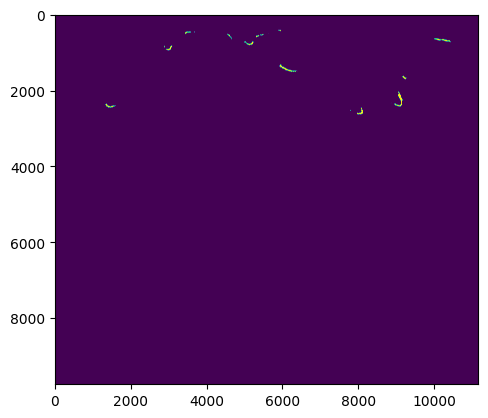

In [236]:

plt.imshow(derm4)


In [57]:
#smoothing epidermis

(width, height) = (dl.width // 10, dl.height // 10)

epi_resized = Image.fromarray(epi).resize((width, height), resample=0)
epi_resized= closing(epi_resized, square(2))
kernel = np.ones((2, 2), np.uint8)
opening = cv2.morphologyEx(epi_resized.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
epi_resized = cv2.dilate(opening, kernel, iterations=2)
epi_smooth = Image.fromarray(epi_resized).resize((dl.width, dl.height),resample=0)

plt.imshow(epi_smooth)


In [ ]:
# 5. iterate each class to replace any potentially wrong pixel to correct class